In [4]:
import matplotlib.pyplot as plt
from qiskit import transpile

In [5]:
import sys
import os

# Get the current working directory (cwd) of the Jupyter notebook
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Now you can import the function from other_script
from single_hopping import *


In [6]:
# Test the consturction of the fermionic operator
i = 0
j = 4
N = 5
H = create_single_hopping_fermionic_operator(i,j,N)
H1 = create_single_hopping_fermionic_operator_test(i,j,N)
print(f"The size of system is {N}, i={i}, j={j}")
print(f"The difference between H and H1 is {np.sum(abs(H-H1))}")



The size of system is 5, i=0, j=4
The difference between H and H1 is 0.0


In [7]:
# Check the operator with the JW transformation in qiskit
t = 1
ops = FermionicOp({"+_" + str(i)+" -_"+str(j): t, "+_" + str(j)+" -_"+str(i):-t}, num_spin_orbitals=N)
mapper = JordanWignerMapper()
jw_op = mapper.map(ops)
jw_op = qi.Operator(jw_op).to_matrix()
jw_op = np.array(jw_op)
eigH = np.linalg.eig(H)[0]
eigJW = np.linalg.eig(jw_op)[0]
eigH = np.sort(1j*eigH)
eigJW = np.sort(1j*eigJW)
print(f"The norm of the eigenvalue of qubit matrix is {np.linalg.norm(eigH)}")
print(f"The norm of the eigenvalue of the JW transformation from Qiskit is {np.linalg.norm(eigJW)}")
print(f"The difference between two eigenvalue vector is {np.sum(abs(eigH - eigJW))}")

The norm of the eigenvalue of qubit matrix is 4.0
The norm of the eigenvalue of the JW transformation from Qiskit is 3.999999999999999
The difference between two eigenvalue vector is 2.886579864025407e-15


In [8]:
# Check the exponential of the operator
y = np.array([[0, -1j], [1j, 0]])
x = np.array([[0, 1], [1, 0]])
z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
A = np.kron(-1j*y/2,x)
B = np.kron(1j*x/2, y)
A = np.kron(A,I)
B = np.kron(B,I)
testH = np.matmul(expm(A), expm(B))

i = 0
j = 1
N = 3
t = 1
expH = create_single_hopping_qubit_exponent(N, i, j, t)
print(abs(expH-testH))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


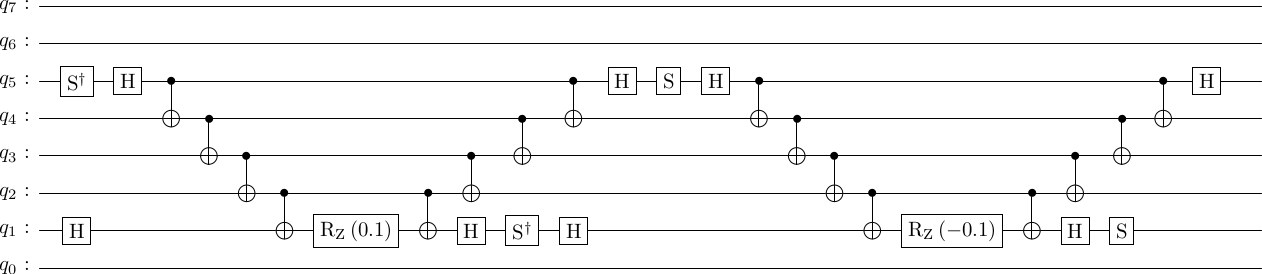

The difference between the matrix of the circuit and the qubit matrix is 1.9362345049050105e-13


In [9]:
# Display the circuit
i = 2
j = 6
N = 8
t = 0.1
expH = create_single_hopping_qubit_exponent(N, i, j, t)
qc = construct_circuit(i,j,N,t)
qc.draw(reverse_bits=True)
M = qi.Operator(qc).to_matrix()
M = np.array(M)
display(qc.draw("latex", reverse_bits=True))
# print(f"The qubit matrix is\n {np.real(expH)}")
# print(f"cos(1) = {np.cos(1)}")
print(f"The difference between the matrix of the circuit and the qubit matrix is {np.sum(abs(expH-M))}")


In [10]:
# Gate count over random circuit
experiment = 5
t = 1
N_lst = np.arange(2,7)
total_gate = np.zeros([experiment, np.size(N_lst)])
total_gate_H = np.zeros([experiment, np.size(N_lst)])
for a in range(np.size(N_lst)):
    N = N_lst[a]
    for k in range(experiment):
        i = np.random.randint(0, N-1)
        j = np.random.randint(i+1, N)
        H = create_single_hopping_qubit_exponent(N, i, j, t)
        qc = construct_circuit(i,j,N,t)
        qc_dict = qc.count_ops()
        basis = ['rx', 'ry', 'rz','cx','h','cz','crx']
        qcH = QuantumCircuit(N)
        qcH.unitary(H, range(0,N))
        qcH = transpile(qcH, basis_gates = basis, optimization_level=0)
        qcH_dict = qcH.count_ops()
        # print(f"I am at {k}, {a}")
        # print(qc_dict.values())
        # print(sum(qc_dict.values()))
        total_gate[k, a] = sum(qc_dict.values())
        total_gate_H[k, a] = sum(qcH_dict.values())
    print(N)


2
3
4
5
6


[[18. 18. 18. 22. 22.]
 [18. 18. 18. 18. 22.]
 [18. 22. 18. 18. 26.]
 [18. 18. 22. 26. 22.]
 [18. 18. 18. 18. 34.]]


Text(0, 0.5, 'Total number of gates')

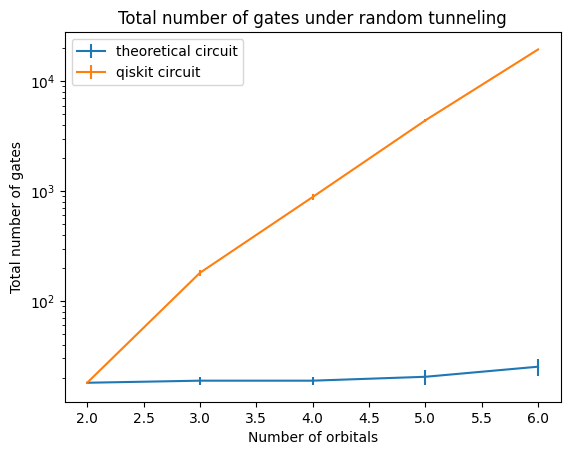

In [11]:
mean_gate = np.mean(total_gate, axis=0)
mean_gate_H = np.mean(total_gate_H, axis=0)
sd_gate = np.sqrt(np.var(total_gate, axis=0))
sdH_gate = np.sqrt(np.var(total_gate_H, axis=0))
plt.errorbar(N_lst, mean_gate, yerr=sd_gate)
plt.errorbar(N_lst, mean_gate_H,yerr=sdH_gate)
plt.yscale("log")
print(total_gate)
plt.legend(["theoretical circuit", "qiskit circuit"])
plt.title("Total number of gates under random tunneling")
plt.xlabel("Number of orbitals")
plt.ylabel("Total number of gates")